# **Machine Learning (PCA)**

In [1]:
# Libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import Image, display

# Data (cleaning and scaling)
df = pd.read_csv('AVONETplusClim.csv')
df_clean = df.copy()
df_clean = df_clean[(df_clean['Mass'] > 0) & (df_clean['Mass'] < 11500)]
df_clean = df_clean[(df_clean['Tail.Length'] > 0.1) & (df_clean['Tail.Length'] < 535)]
df_clean = df_clean[(df_clean['Tarsus.Length'] > 0) & (df_clean['Tarsus.Length'] < 350)]
df_clean = df_clean[(df_clean['Wing.Length'] > 0.1) & (df_clean['Wing.Length'] < 650)]
df_clean = df_clean[df_clean['Hand-Wing.Index'] > 3]
df_clean['Log_Mass'] = np.log10(df_clean['Mass'])
df_clean['Log_Tail'] = np.log10(df_clean['Tail.Length'])
df_clean['Log_Tarsus'] = np.log10(df_clean['Tarsus.Length'])
df_clean['Log_Beak'] = np.log10(df_clean['Beak.Length_Culmen'])
df_clean['Log_Wing'] = np.log10(df_clean['Wing.Length'])
df_clean['Log_HWI'] = np.log10(df_clean['Hand-Wing.Index'])

In [2]:
features = ['Log_Mass', 'Log_Beak', 'Log_Wing', 'Log_Tarsus', 'Log_Tail', 'Log_HWI']
categories = ['Trophic.Niche', 'Primary.Lifestyle', 'Habitat', 'Migration', ]

X = df_clean[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

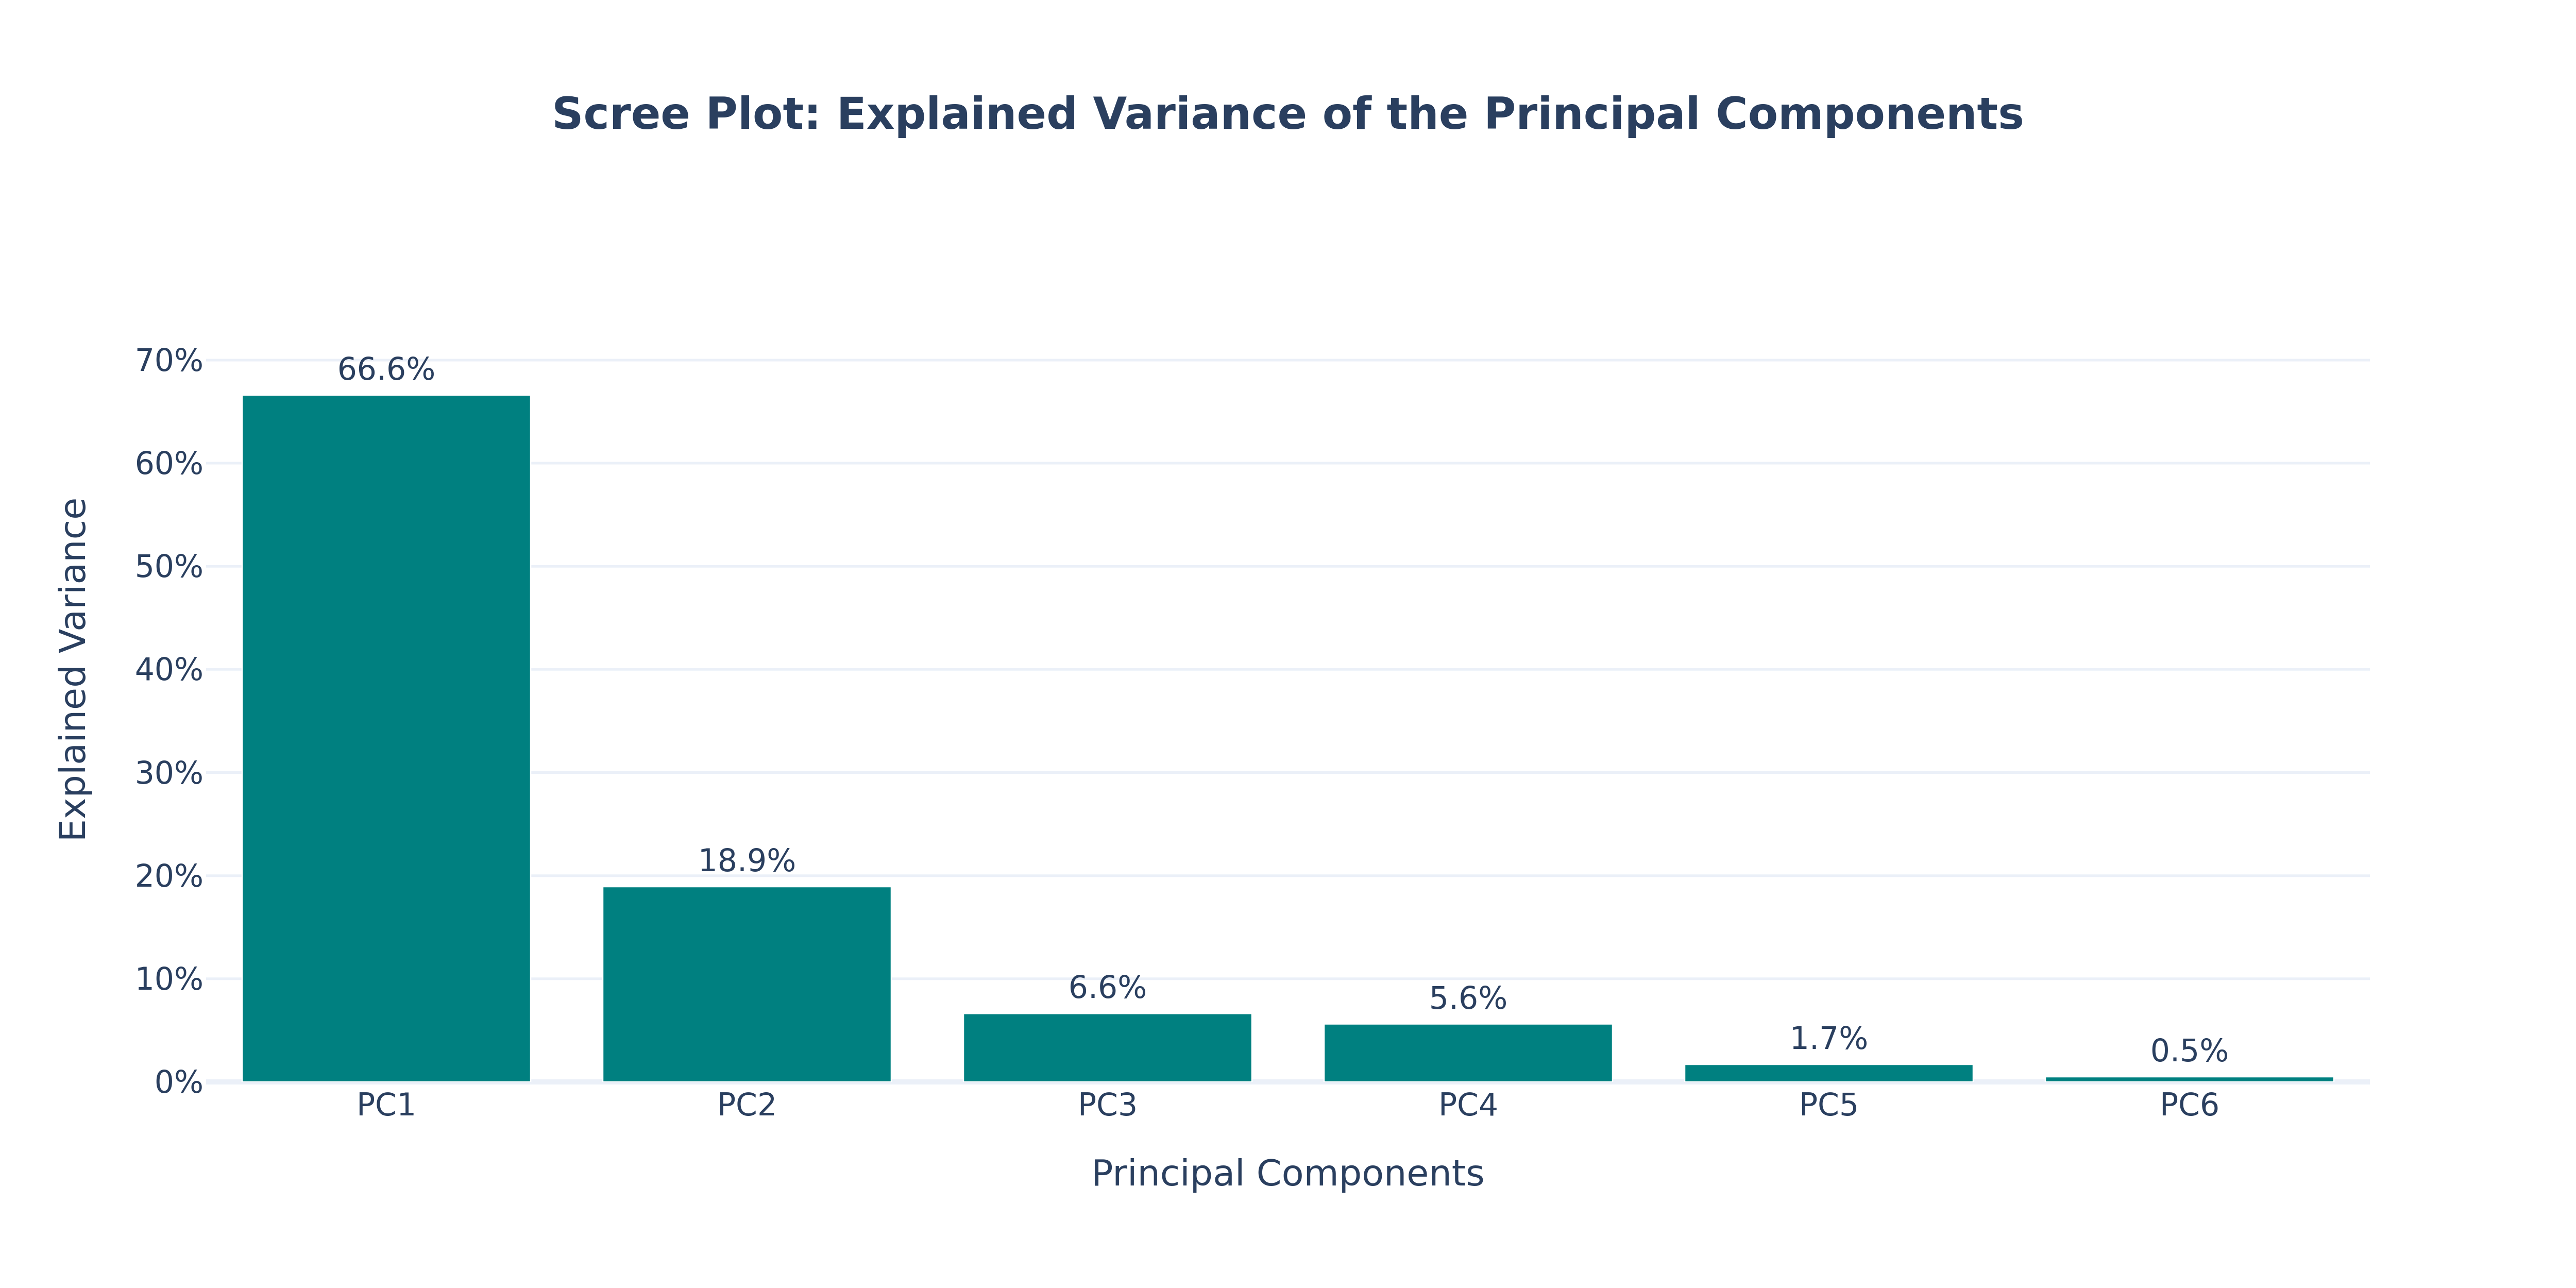

In [3]:
pca_full = PCA()
pca_full.fit(X_scaled)

explained_variance_ratio = pca_full.explained_variance_ratio_
labels = [f'PC{i+1}' for i in range(len(explained_variance_ratio))]

fig_scree = go.Figure()

fig_scree.add_trace(go.Bar(
    x=labels, 
    y=explained_variance_ratio,
    name='Explained Variance Ratio',
    marker_color='teal',
    text=explained_variance_ratio,
    texttemplate='%{text:.1%}',
    textposition='outside'
))

fig_scree.update_layout(
    title='<b>Scree Plot: Explained Variance of the Principal Components</b>', 
    title_x=0.5, 
    xaxis_title='Principal Components', 
    yaxis_title='Explained Variance',
    template='plotly_white', 
    width=1000,
    height=500,
    yaxis_tickformat='.0%',
    yaxis=dict(range=[0, max(explained_variance_ratio) * 1.2]) 
)

file_name = "PCA_Scree_Plot.png"
fig_scree.write_image(file_name, scale=5)
display(Image(file_name))

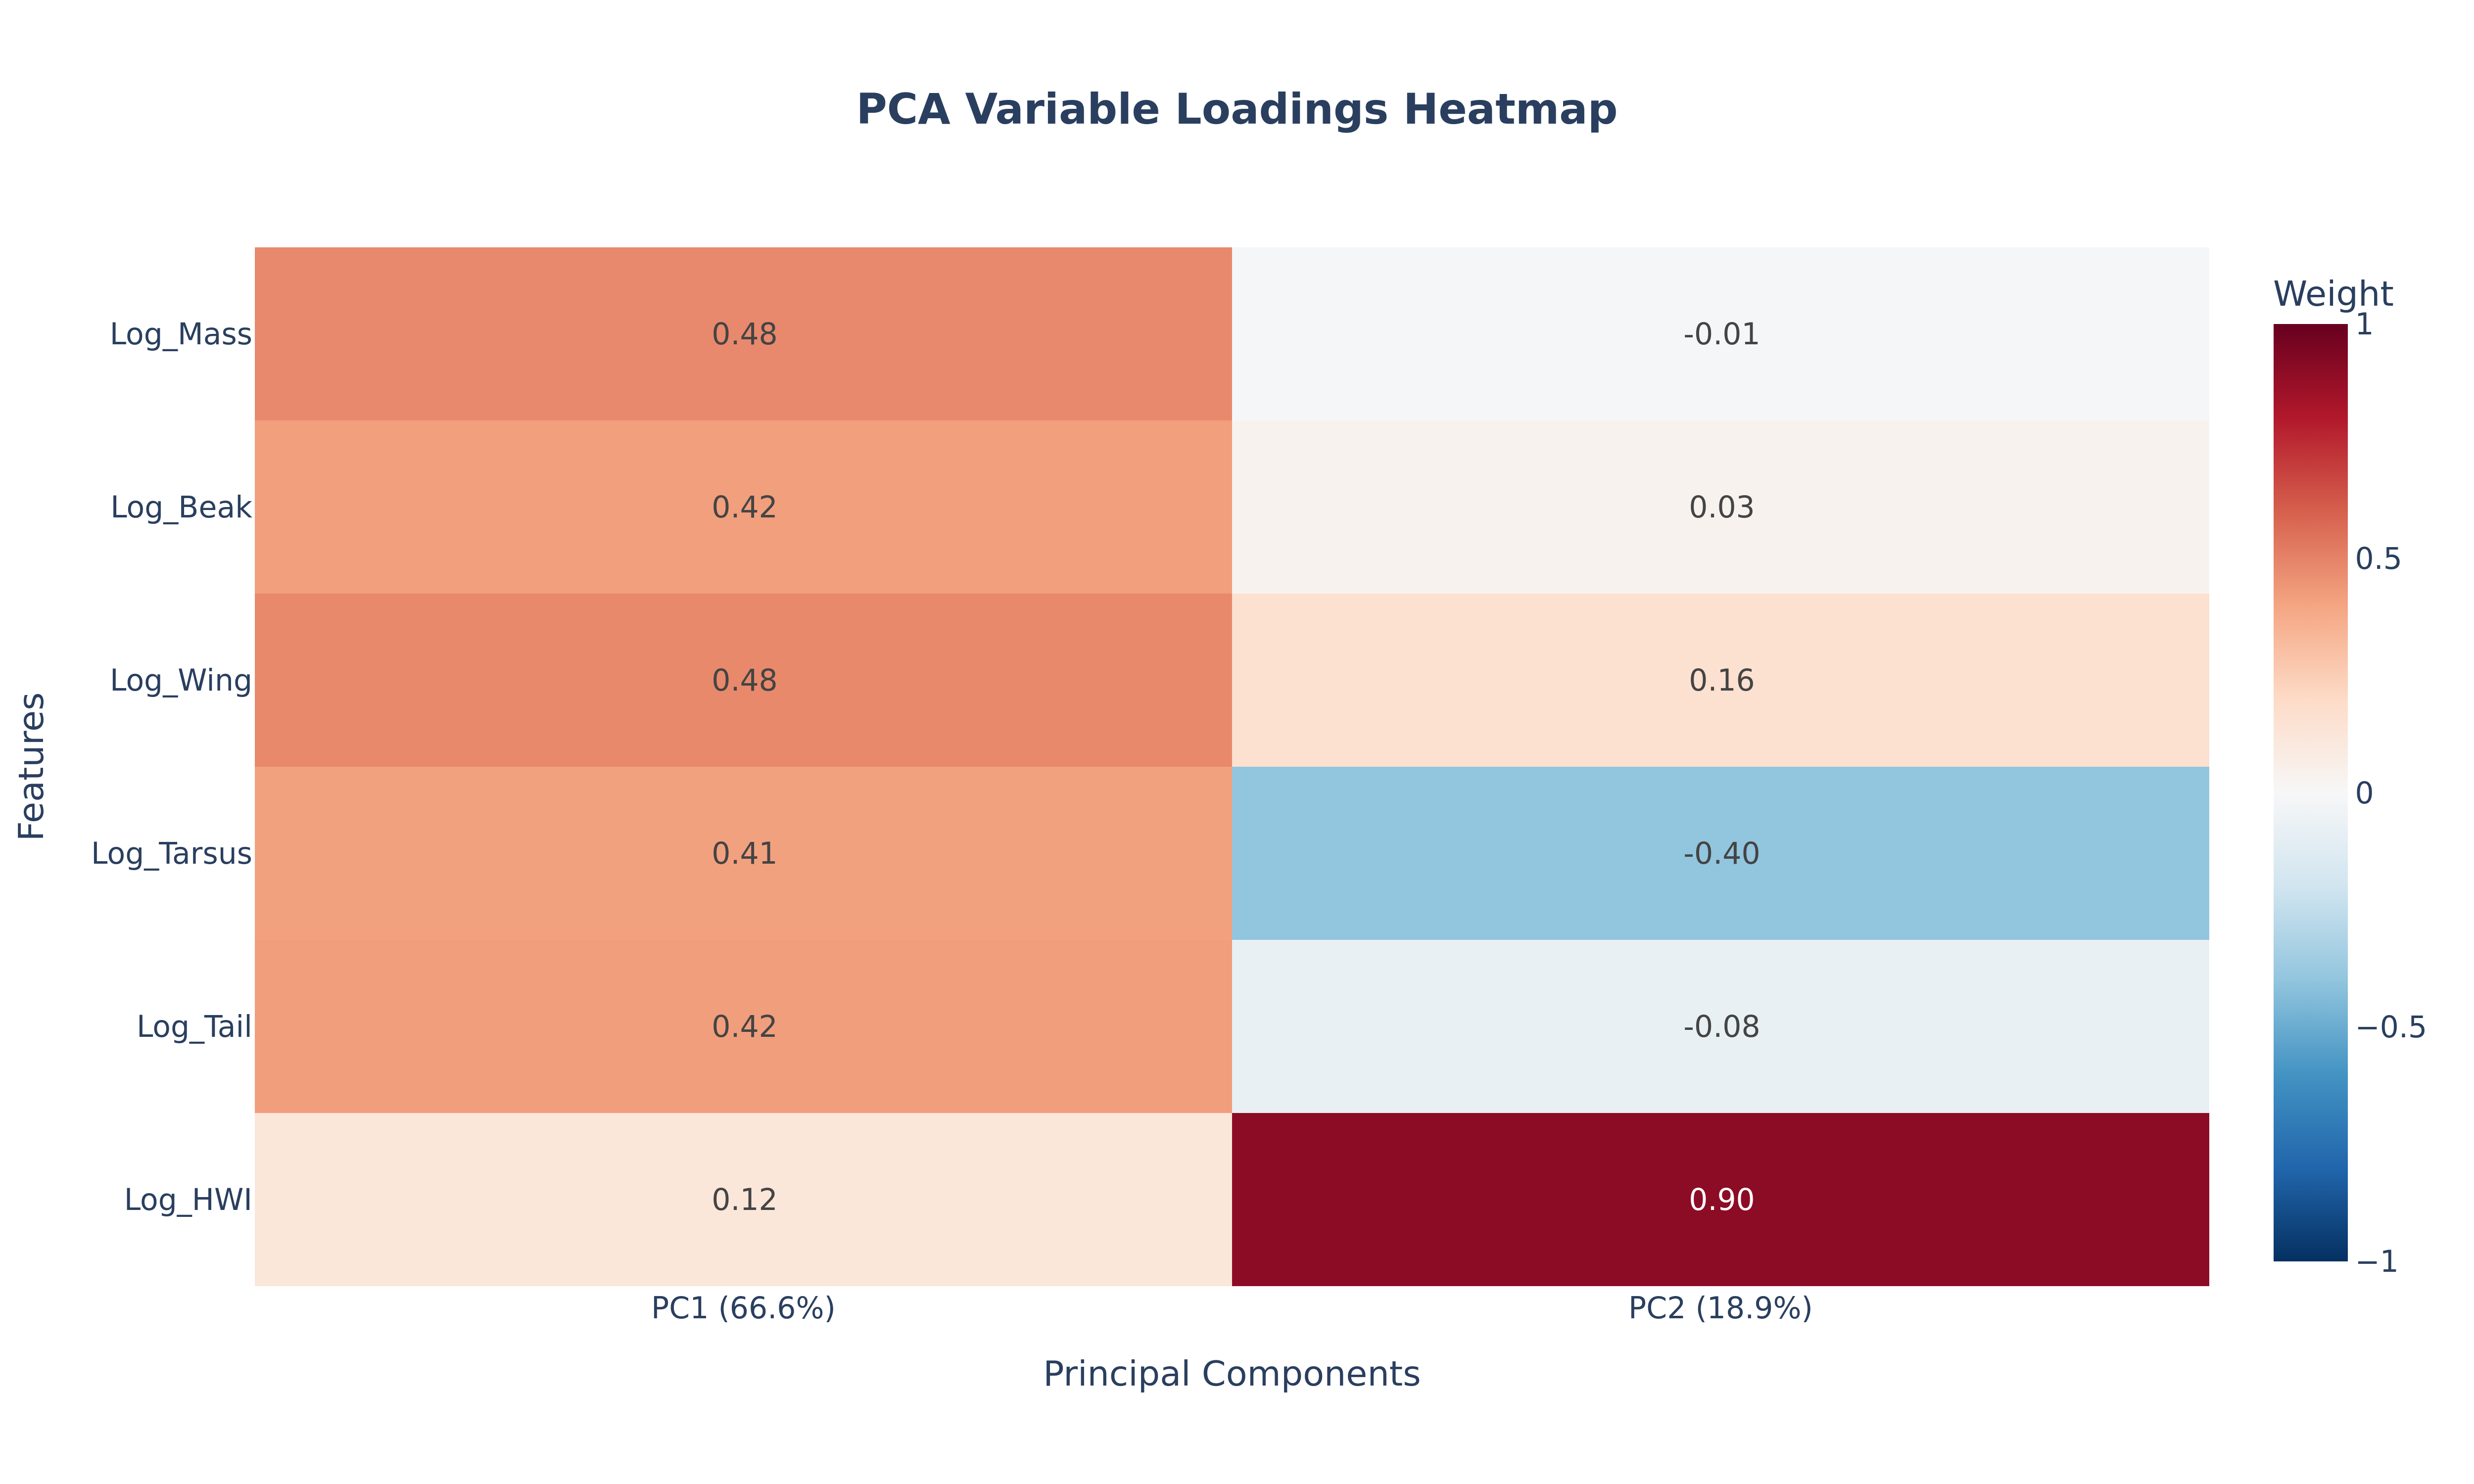

In [4]:
pca_2d = PCA(n_components=2)
components = pca_2d.fit_transform(X_scaled)

df_clean['PC1'] = components[:, 0]
df_clean['PC2'] = components[:, 1]
var = pca_2d.explained_variance_ratio_ * 100

loadings = pca_2d.components_.T

pc_labels_heatmap = [f'PC1 ({var[0]:.1f}%)', f'PC2 ({var[1]:.1f}%)']

fig_heat = px.imshow(
    loadings,
    labels=dict(x="Principal Components", y="Features", color="Weight"),
    x=pc_labels_heatmap, 
    y=features,
    color_continuous_scale='RdBu_r', 
    zmin=-1, zmax=1,
    text_auto='.2f', 
    aspect="auto", 
    title='<b>PCA Variable Loadings Heatmap</b>'
)

fig_heat.update_layout(
    title_x=0.5,
    width=1000,
    height=600,
    margin=dict(t=100),
    template='plotly_white'
)

file_name = "PCA_Loadings_Heatmap.png"
fig_heat.write_image(file_name, scale=5)
display(Image(file_name))

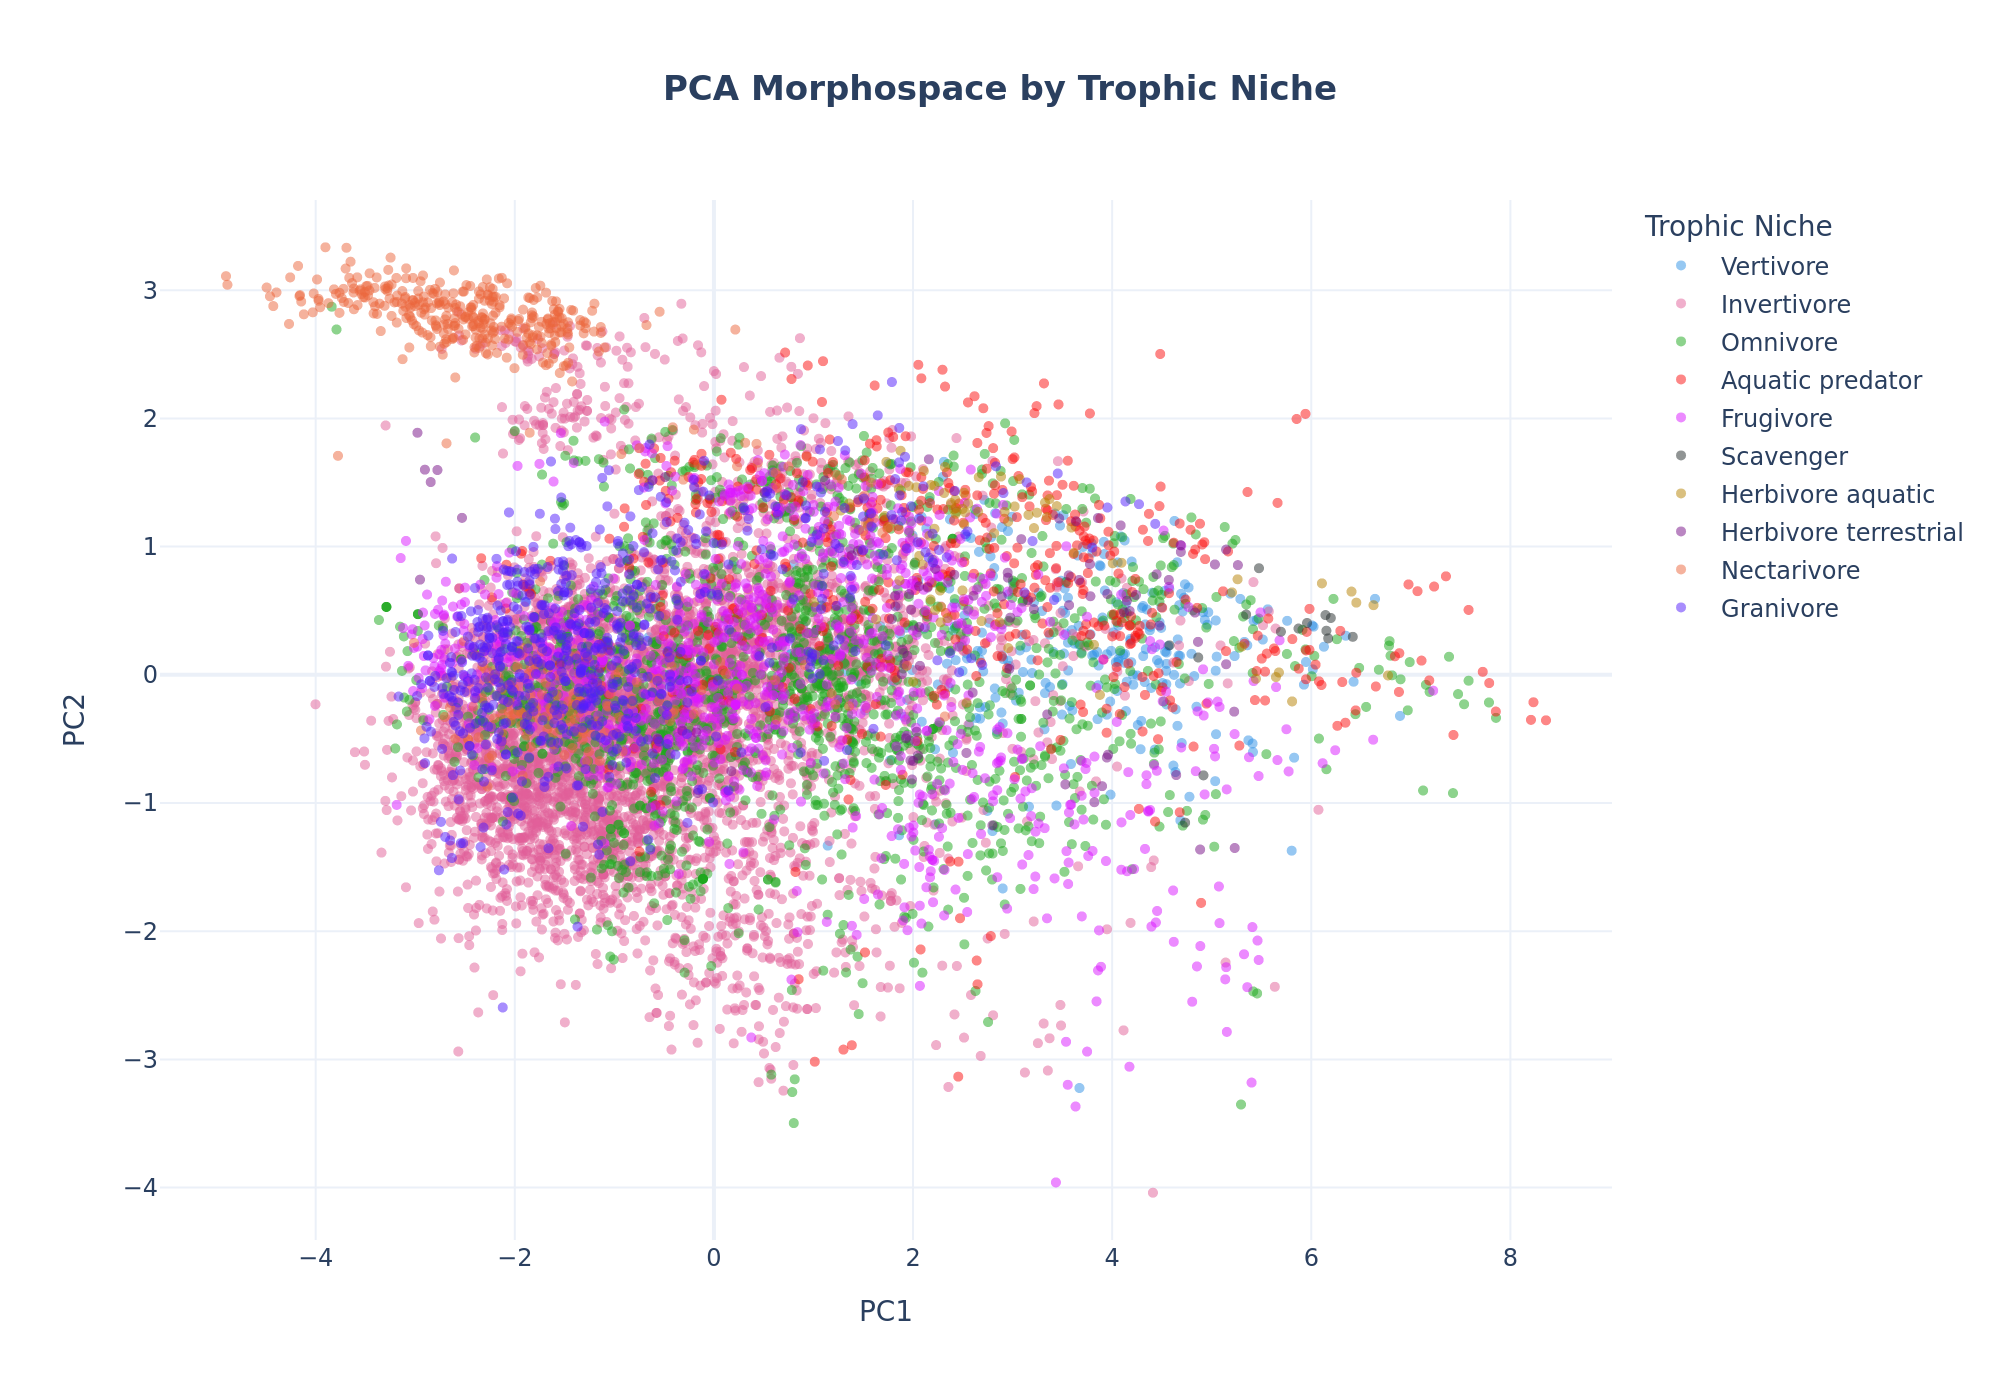

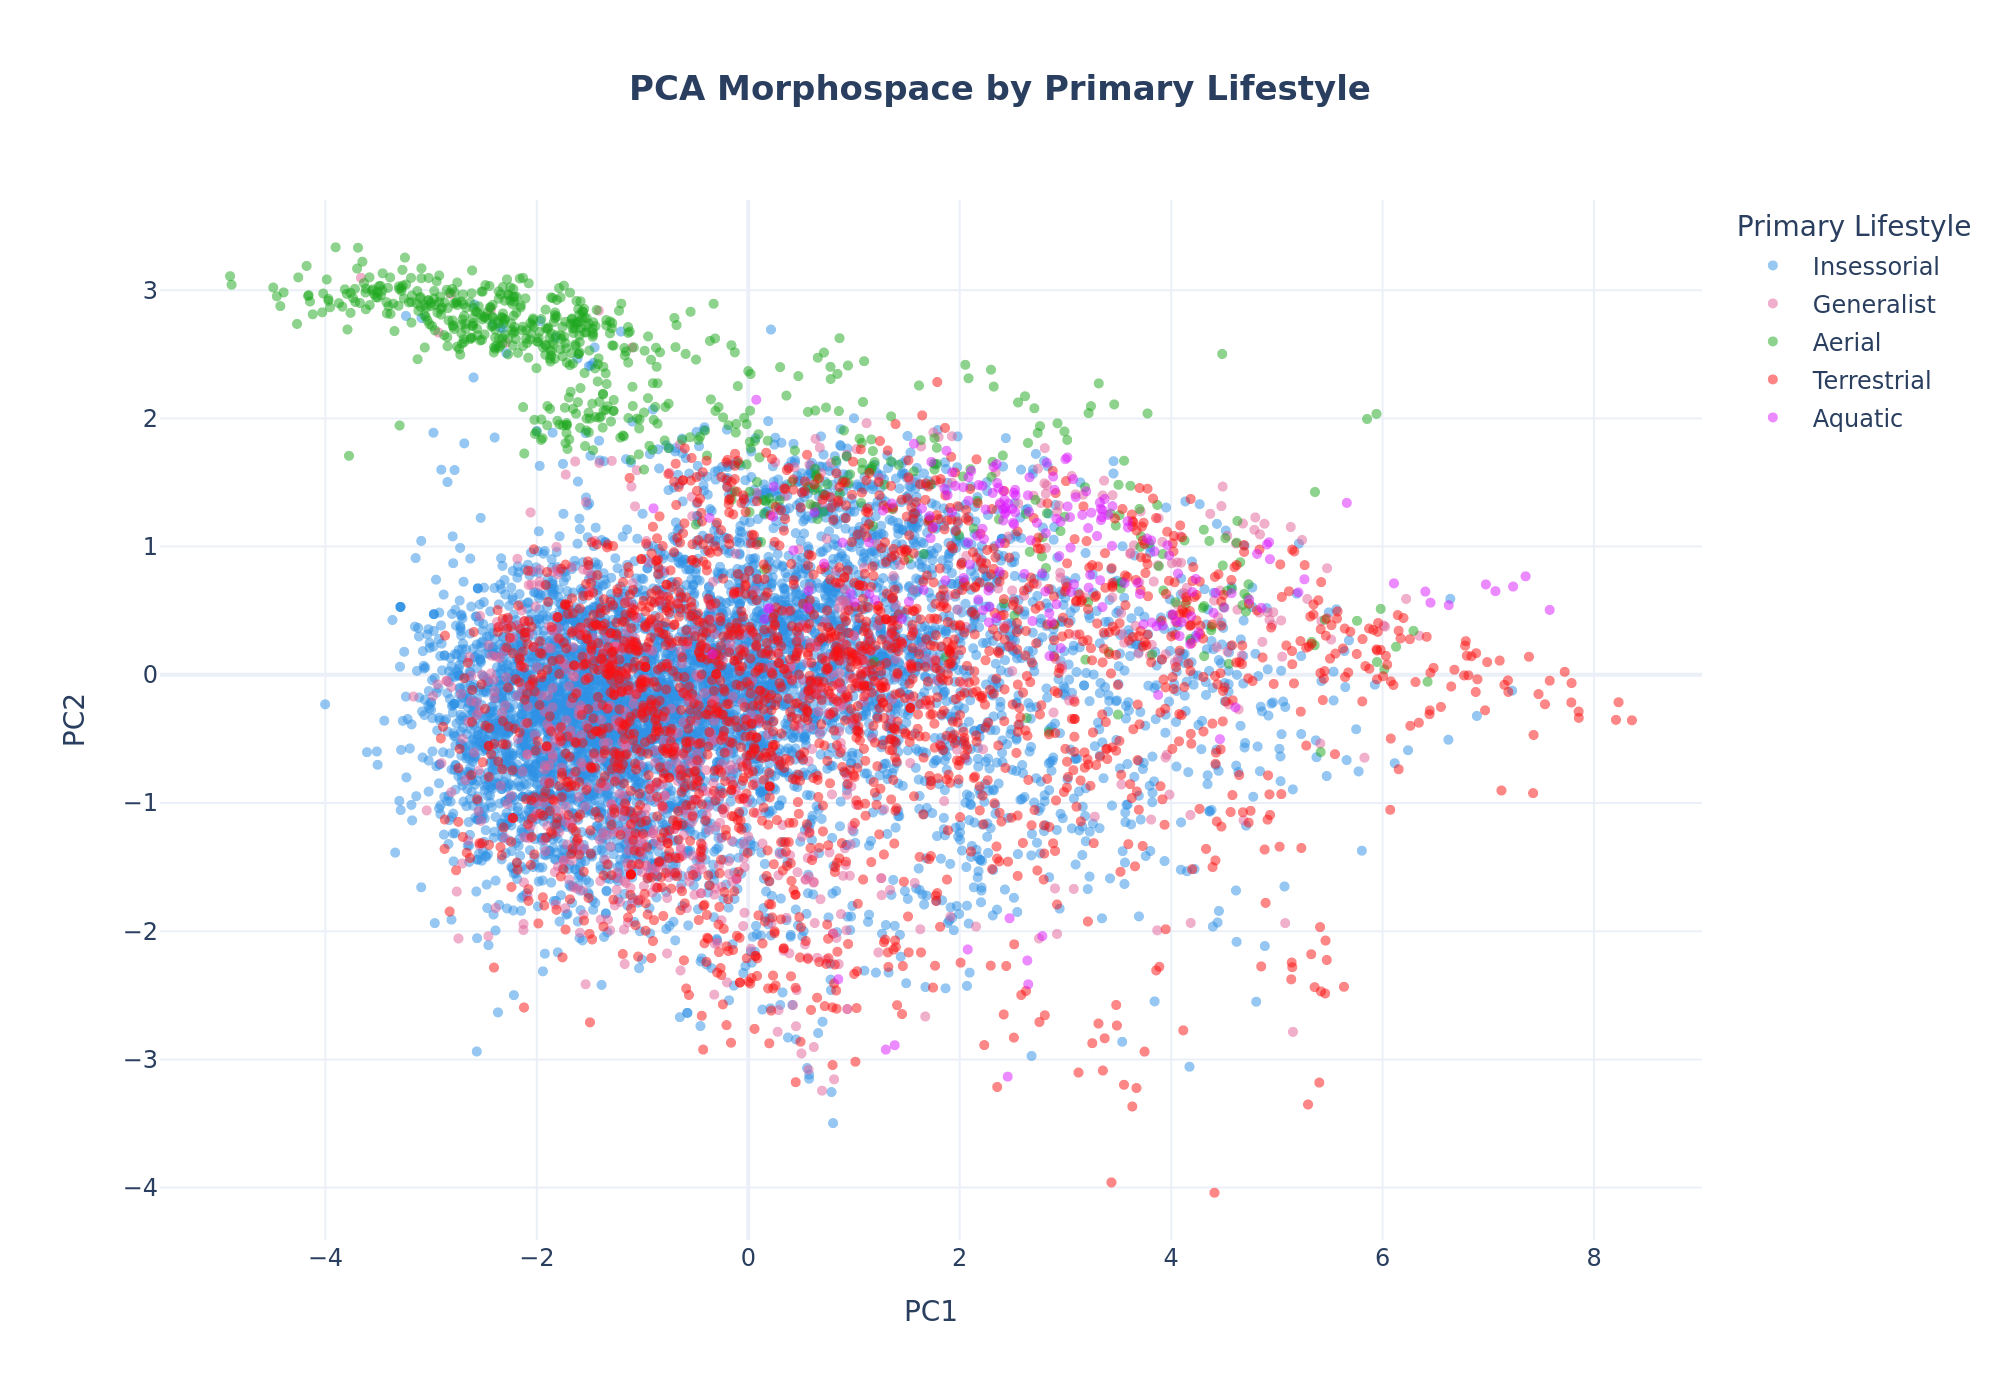

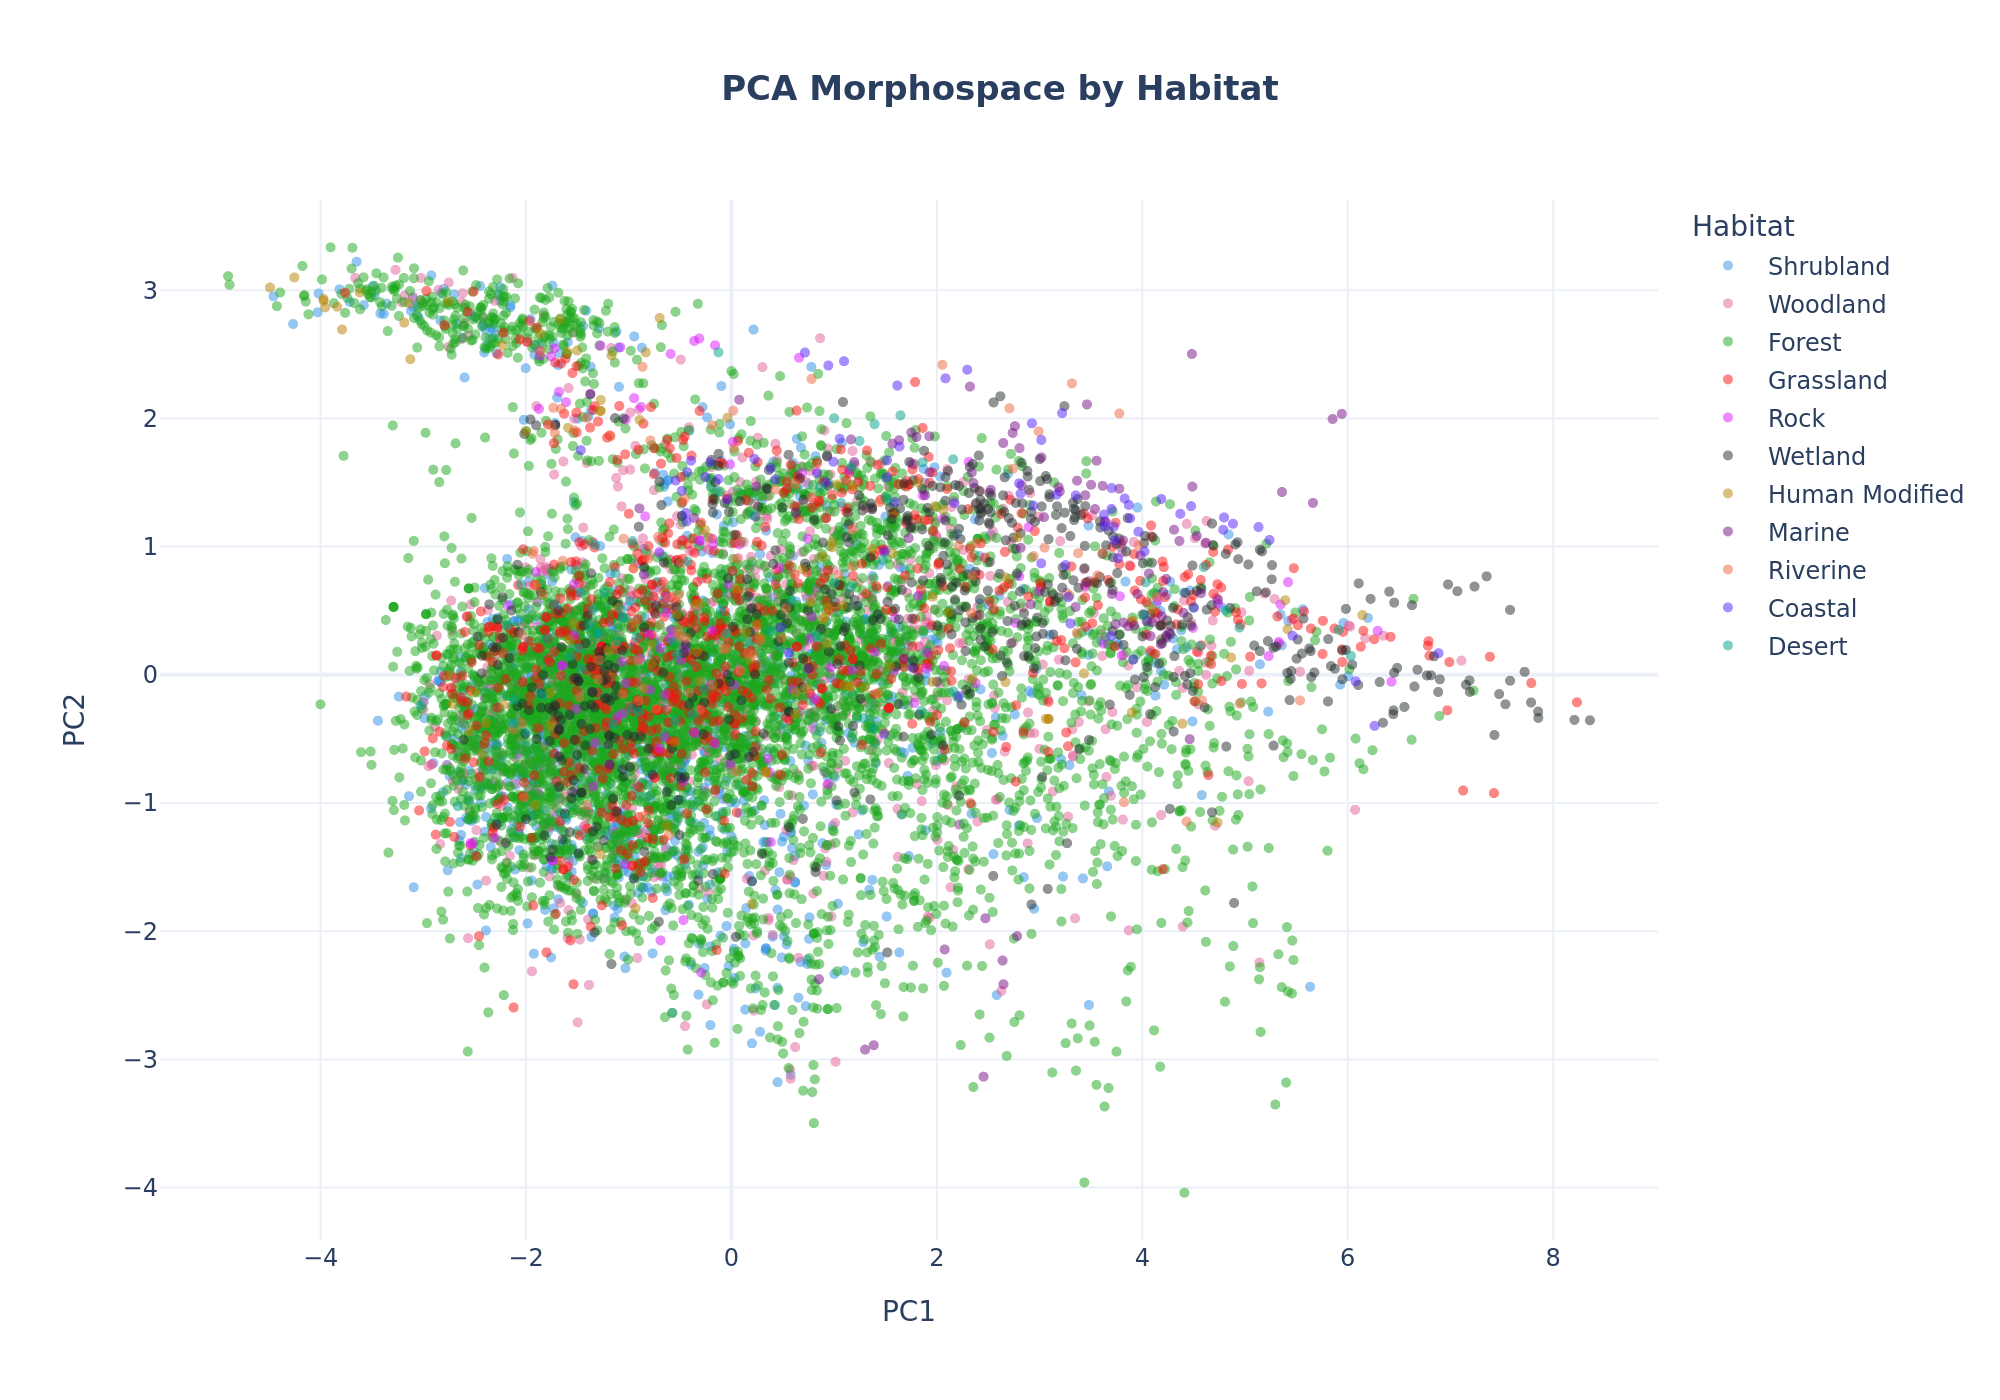

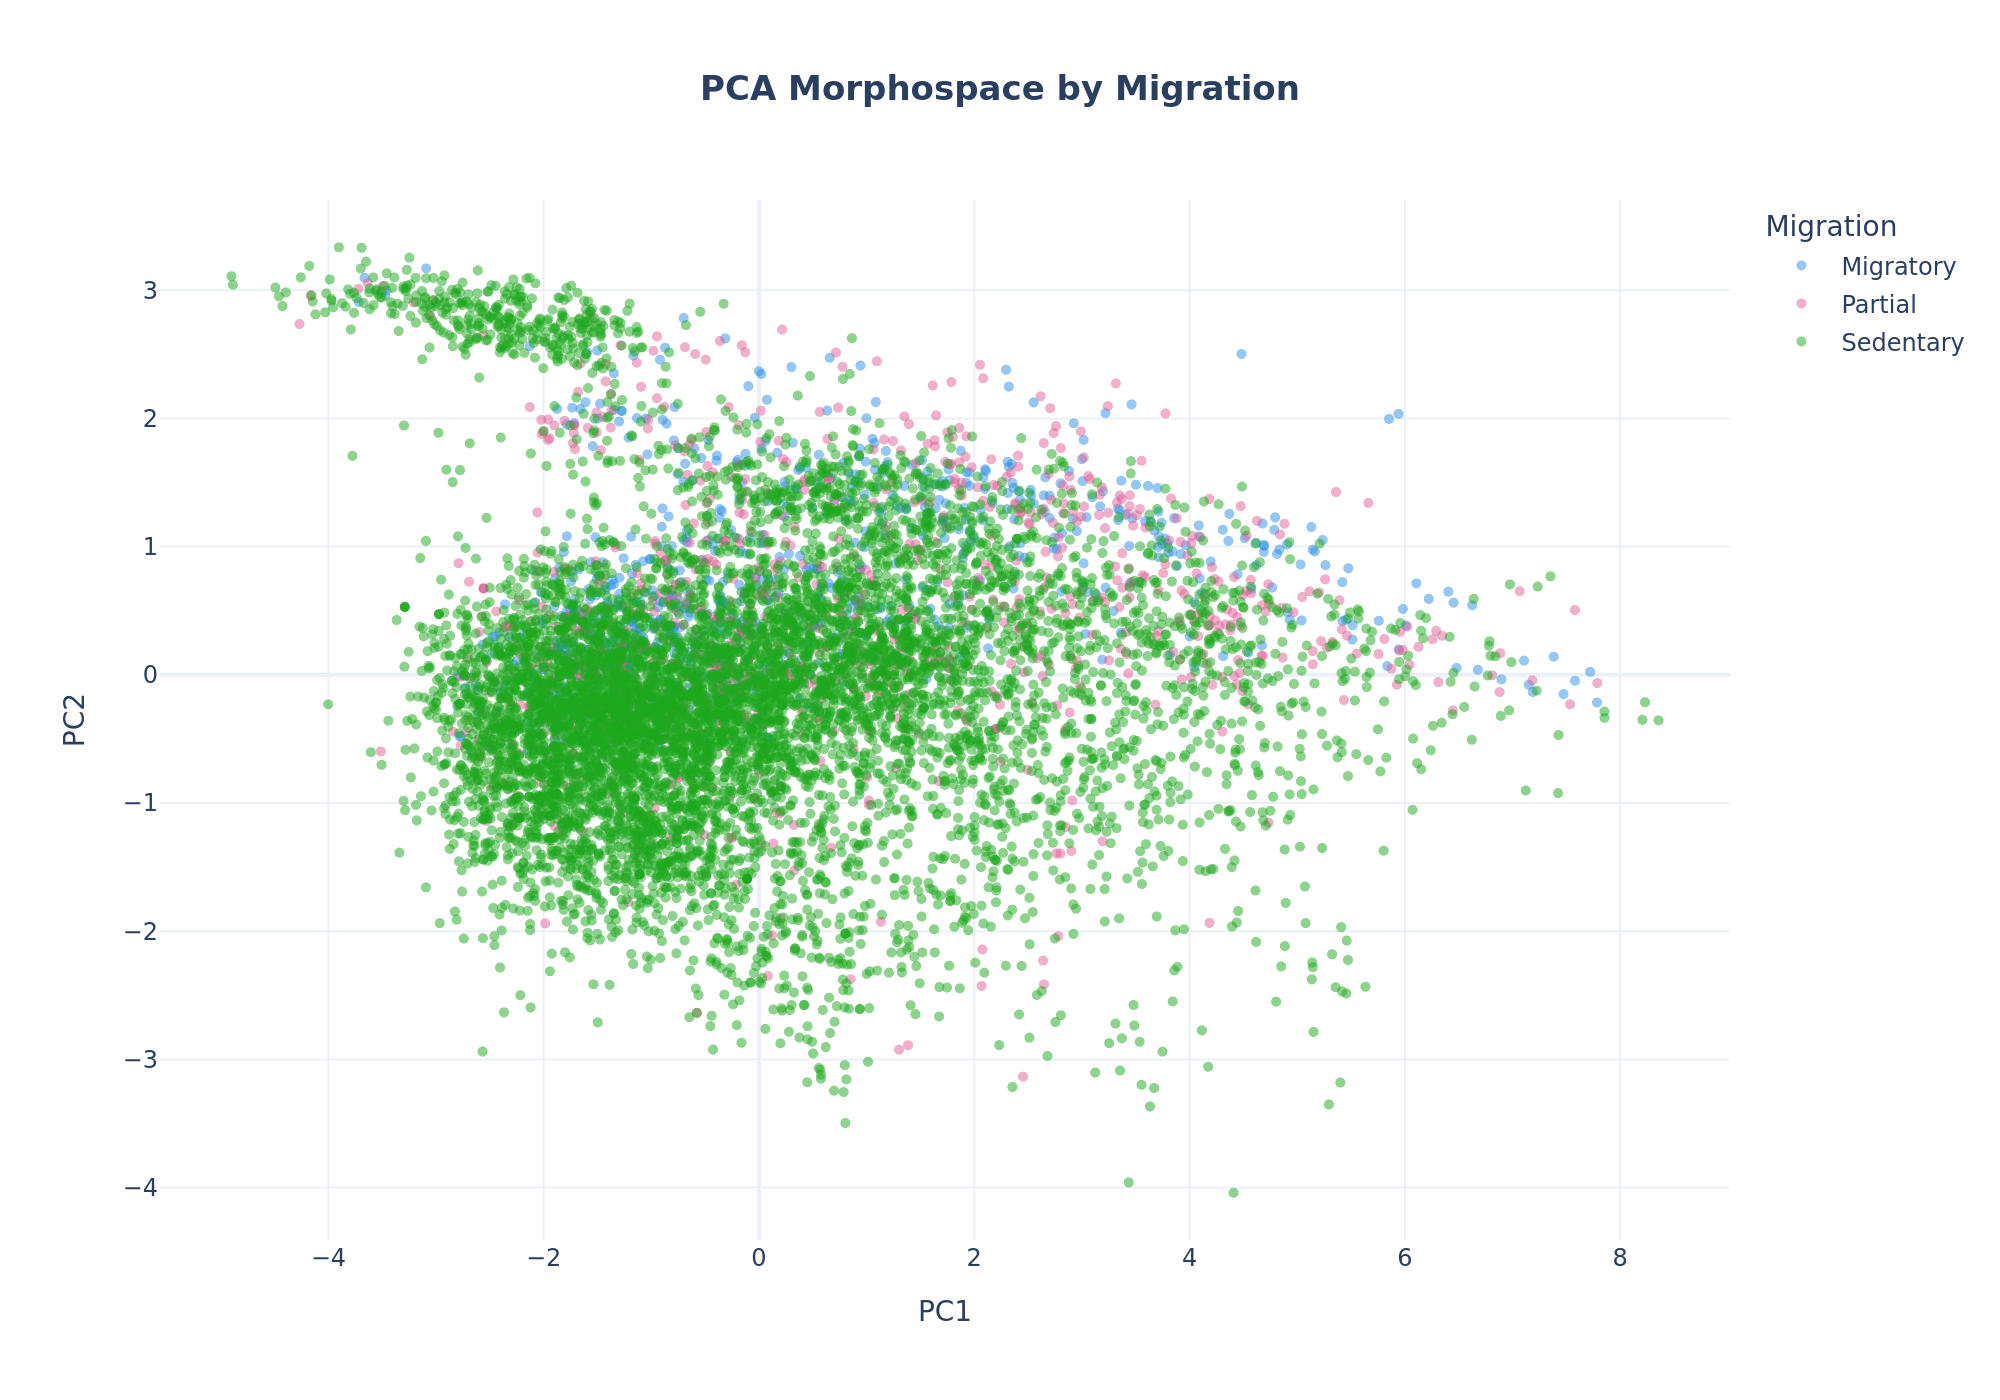

In [6]:
x_min, x_max = df_clean['PC1'].min(), df_clean['PC1'].max()
y_min, y_max = df_clean['PC2'].min(), df_clean['PC2'].max()
x_padding = (x_max - x_min) * 0.05
y_padding = (y_max - y_min) * 0.05
x_range = [x_min - x_padding, x_max + x_padding]
y_range = [y_min - y_padding, y_max + y_padding]

for cat in categories:
    if cat in df_clean.columns:
        clean_name = cat.replace('.', ' ').replace('_', ' ')
        
        fig = px.scatter(
            df_clean, 
            x='PC1', 
            y='PC2', 
            color=cat,
            color_discrete_sequence=px.colors.qualitative.Dark24,
            title=f'<b>PCA Morphospace by {clean_name}</b>',
            template='plotly_white',
            opacity=0.5,
            labels={cat: clean_name},
            hover_name='Species' if 'Species' in df_clean.columns else None
        )

        fig.update_traces(marker=dict(size=5))

        fig.update_layout(
            title_x=0.5,
            width=1000, 
            height=700, 
            legend_title_text=clean_name,
            xaxis=dict(range=x_range, autorange=False, title="PC1"),
            yaxis=dict(range=y_range, autorange=False, title="PC2")
        )

        base_name = f"PCA_Morphospace_{cat.replace('.', '_')}"
        fig.write_image(f"{base_name}.png", scale=2)
        fig.write_html(f"{base_name}.html", include_plotlyjs='cdn')
        display(Image(f"{base_name}.png"))